In [1]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import calendar

In [2]:
s_path=Path.cwd()
s_prt_path=s_path.parent

objetoAPI = pydataxm.ReadDB()                    #Se almacena el servicio en el nombre objetoAPI
df =objetoAPI.get_collections()   

# df.to_csv('Collections.csv')
# df.head(5)

In [3]:
# Lectura de datos de enrtrada para el cálculo
s_parentpath=Path('C:\Alejo\EVE')
filepath=s_parentpath.joinpath(s_parentpath,'DatosEntrada.xlsx')

# Carga del nivel probabilístico del embalse
sheet_name='NEP%_mes'
NEPmes=pd.read_excel(filepath, header=0,sheet_name=sheet_name)
NEPmes=NEPmes.set_index('Embalse_Sinergox')

# Carga del nivel probabilístico de vertimiento
sheet_name='NPV%_mes'
NPVmes=pd.read_excel(filepath, header=0,sheet_name=sheet_name)
NPVmes=NPVmes.set_index('Embalse_Sinergox')

# Carga de la relación Embalse-Planta
sheet_name='Rel_Emb_Plt'
Rel_Emb_Plt=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

# Carga los parámetros del embalse
sheet_name='Par_Embalse'
Par_Emb=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

# Carga los parámetros del embalse
sheet_name='CurvaEmbalse'
Par_CurEmb=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

# Relación planta embalse
df_DataPlt=Rel_Emb_Plt.copy()
df_DataPlt=df_DataPlt[['Planta_Sinergox','CodigoSIC','Embalse_Sinergox','FC_Planta','Plt_Despacho']]
df_DataPlt=df_DataPlt.dropna().drop_duplicates()

In [4]:
# Dscargar información de los archivos de liquidación
FechaIniLiq=dt.date(2024, 10, 1)
FechaFinLiq=dt.date(2024, 11, 29)

# Ruta archivo
sRutaLiq=r'C:\Información XM\PUBLICOK\SIC\COMERCIA\\'
l_FIles=['ContEVEini1031.tx1','ContEVEini1129.tx1']
df_Liq=pd.DataFrame()
for sFIle in l_FIles:
    sFilePath=Path(sRutaLiq + '2024-' + sFIle[10:12] + '\\' + sFIle)

# l_col=['AGENTE','RECURSO','CONCEPTO','FECHA','VALOR']

    df_LiqAux = pd.read_csv(sFilePath, sep=';',header=0,encoding="ISO-8859-1")

    df_Liq=pd.concat([df_Liq,df_LiqAux],axis=0)

In [5]:
# Extraer la información de QEVE, EVE y GEVE
l_conceptos=['QEVE','EVE','GEVE']

df_dataSIC=pd.DataFrame()

for sCon in l_conceptos:
    # Obtener la QEVE del archivo de liquidación
    df_dataAux=df_Liq[(df_Liq.CONCEPTO==sCon)]
    df_dataAux['VALOR']=df_dataAux['VALOR'].astype(float)/1e6
    df_dataAux['FECHA']=pd.to_datetime(df_dataAux['FECHA'])
    df_dataAux = df_dataAux.drop_duplicates(subset=['AGENTE', 'RECURSO', 'CONCEPTO', 'FECHA'])

    l_Fechas=pd.to_datetime(df_dataAux['FECHA'].drop_duplicates().reset_index(drop=True))
    l_Recursos=df_dataAux['RECURSO'].drop_duplicates().reset_index(drop=True)

    df_single_day = pd.DataFrame({'RECURSO':l_Recursos})

    # Repeat the single day data across multiple dates
    df_dataAux1 = pd.concat([df_single_day.assign(FECHA=date) for date in l_Fechas], ignore_index=True)

    df_dataAux1=df_dataAux1.merge(df_dataAux,left_on=['FECHA','RECURSO'],right_on=['FECHA','RECURSO'], how='left')[['FECHA','RECURSO', 'CONCEPTO', 'VALOR']]
    df_dataAux1['CONCEPTO'].fillna(sCon,inplace=True)
    df_dataAux1['VALOR'].fillna(0,inplace=True)
    df_dataAux1=df_dataAux1.merge(df_DataPlt[['Planta_Sinergox','CodigoSIC']].drop_duplicates(),left_on=['RECURSO'],right_on=['CodigoSIC'], how='left')[['FECHA','CodigoSIC','Planta_Sinergox', 'CONCEPTO', 'VALOR']]

    df_dataSIC=pd.concat([df_dataSIC,df_dataAux1],axis=0)

df_QEVE=df_dataSIC[(df_dataSIC.CONCEPTO=='QEVE')]
df_QEVE=df_QEVE.rename(columns={'Planta_Sinergox':'Planta'})

df_EVE=df_dataSIC[(df_dataSIC.CONCEPTO=='EVE')]
df_EVE=df_EVE.rename(columns={'Planta_Sinergox':'Planta'})

df_GEVE=df_dataSIC[(df_dataSIC.CONCEPTO=='GEVE')]
df_GEVE=df_GEVE.rename(columns={'Planta_Sinergox':'Planta'})

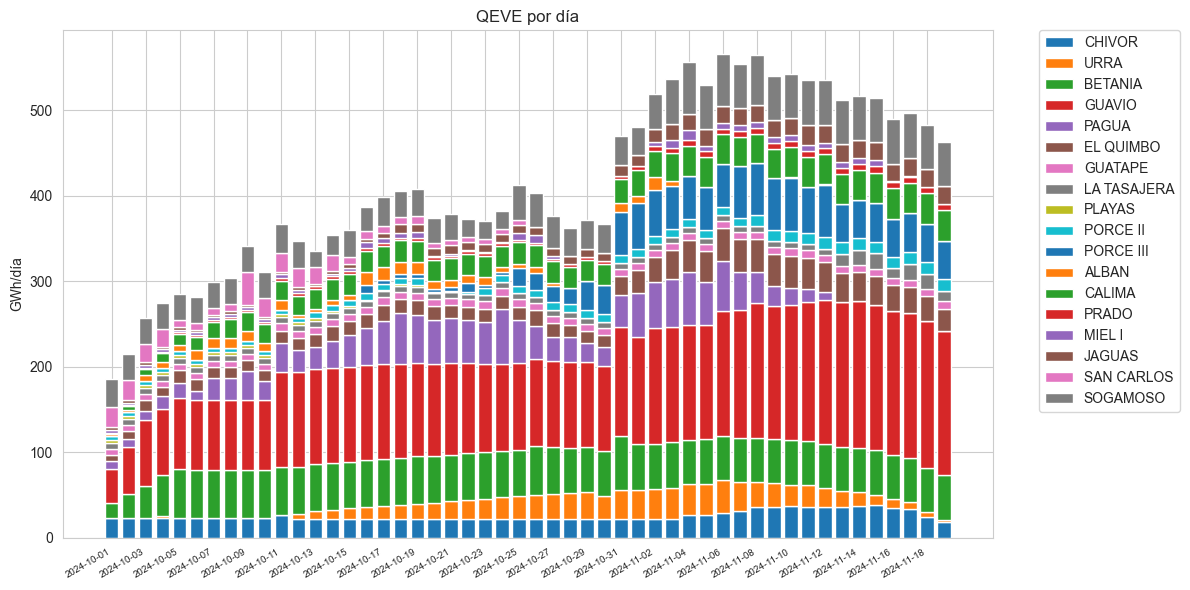

In [6]:
# Plotting QEVE por agente
sns.set_style("whitegrid")
categories = pd.to_datetime(df_QEVE['FECHA'].drop_duplicates().reset_index(drop=True))
segments = df_QEVE['Planta'].drop_duplicates().reset_index(drop=True)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Cumulative bottom values for stacking
bottom_values = [0] * len(df_QEVE[(df_QEVE.Planta=='CHIVOR')]['VALOR'].reset_index(drop=True))

# Loop through each segment to stack
for segment in segments:
    ax.bar(categories, df_QEVE[(df_QEVE.Planta==segment)]['VALOR'].reset_index(drop=True), label=segment, bottom=bottom_values)
    # Update bottom values for next stack
    bottom_values += df_QEVE[(df_QEVE.Planta==segment)]['VALOR'].reset_index(drop=True)


# Label and legend
ax.set_ylabel("GWh/día")
ax.set_title("QEVE por día")
ax.legend(title="Segments")

plt.xticks(pd.date_range(categories.min(), categories.max(), freq='2D'), rotation=90)
plt.tick_params(axis='x', labelsize=7)
plt.gcf().autofmt_xdate()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()  # Adjust layout to make room for the legend

plt.show()

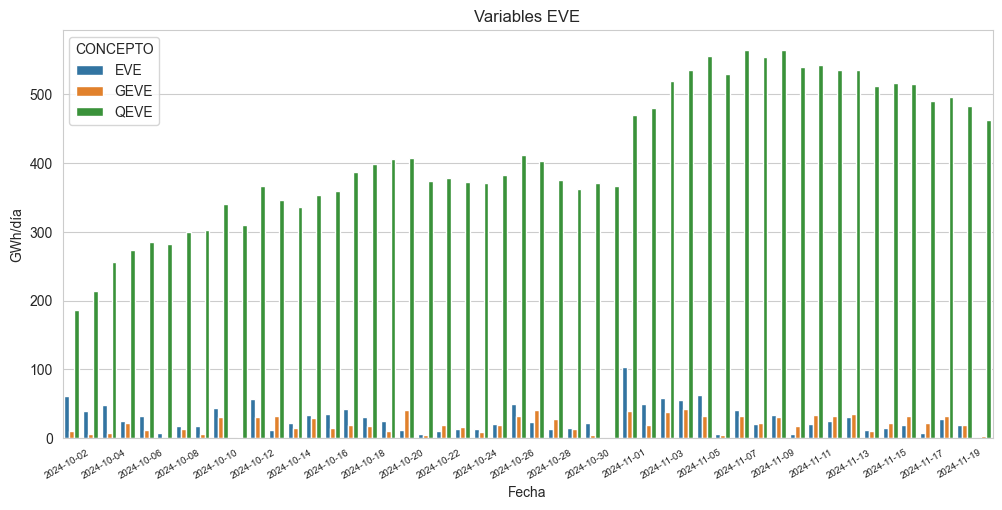

In [7]:
# Plot QEVE, EVE, GEVE sistema
import matplotlib.dates as mdates

def plotEVE(df_DataDay,sX,sY,sH,ticks=1):
    # Create the bar plot
    plt.figure(figsize=(12, 6))

    if sH=='NA':
        sns.barplot(data=df_DataDay, x=sX, y=sY)
    else:
        sns.barplot(data=df_DataDay, x=sX, y=sY, hue=sH)

    # Set plot title and labels
    plt.title('Variables EVE')
    plt.xlabel('Fecha')
    plt.ylabel('GWh/día')

    if ticks==1:
        # Format the x-ticks to show every second date
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Show every 2nd date
        plt.tick_params(axis='x', labelsize=7)
        plt.gcf().autofmt_xdate()
    else:
        plt.gcf().autofmt_xdate()
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Display the plot
    plt.show()

df_DataDay=df_dataSIC.groupby(['FECHA','CONCEPTO'])[['VALOR']].sum()
df_DataDay=df_DataDay.reset_index()

plotEVE(df_DataDay,sX='FECHA',sY='VALOR',sH='CONCEPTO',ticks=1)


In [8]:
# Leer archivos del con la información del despacho
FechaIniDes=dt.date(2024, 9, 30)
# FechaFin=dt.date(2024, 9, 30)
FechaFinDes=dt.date(2024, 11, 20)

day = dt.timedelta(days=1)

FechaIter=FechaIniDes

df_dataD=pd.DataFrame()

while FechaIter <= FechaFinDes:
    
#     print(FechaIter)
    ano = FechaIter.year
    mes=FechaIter.month
    dia=FechaIter.day
    
    ruta=r"C:\Información XM\Publico\OFERTAS\EVE\\"
    ruta= ruta + str(ano) + '-' + "{:02d}".format(mes) + '\\'
    ruta= ruta + 'Aju' + "{:02d}".format(mes) + "{:02d}".format(dia) + '.txt'
    df_aux = pd.read_csv(ruta, sep=',', header=0,encoding="ISO-8859-1")
    df_aux.columns = df_aux.columns.str.replace(' ', '', regex=True)
    df_aux['Fecha(t+1)']=pd.to_datetime(df_aux['Fecha(t+1)'])
    df_aux['Recurso']=df_aux['Recurso'].str.strip()

    if df_aux.shape[1]<6:
            df_aux['PrecioInicial(t+1)']=0
            df_aux['PrecioConsolidado(t+1)']=0

            df_aux=df_aux[['Fecha(t+1)', 'Recurso', 'Compra(t+1)', 'PrecioInicial(t+1)','PrecioConsolidado(t+1)', 'CausaAjuste(t+1)', 'BanderaEntrega(t+1)']]
    
    ruta=r"C:\Información XM\Publico\OFERTAS\EVE\\"
    ruta= ruta + str(ano) + '-' + "{:02d}".format(mes) + '\\'
    ruta= ruta + 'SoCond' + "{:02d}".format(mes) + "{:02d}".format(dia) + '.txt'
    df_aux1 = pd.read_csv(ruta, sep=',', header=0,encoding="ISO-8859-1")
    df_aux1.columns = df_aux1.columns.str.replace(' ', '', regex=True)
    df_aux1['Recurso']=df_aux1['Recurso'].str.strip()
    df_aux1=df_aux1.rename(columns={'Recurso':'Recurso1'})

    df_aux=df_aux.merge(df_aux1,left_on=['Recurso'],right_on=['Recurso1'],how='left')[['Fecha(t+1)', 'Recurso', 'Compra(t+1)', 'PrecioInicial(t+1)','PrecioConsolidado(t+1)'
                                                                                      , 'CausaAjuste(t+1)', 'BanderaEntrega(t+1)','Embalse', 'NE(t-1)', 'NPV(t-1)', 'NEP(t)'
                                                                                      , 'Compromiso(t)','EntregaEstimada(t)']]

    df_dataD=pd.concat([df_dataD,df_aux])



    FechaIter=FechaIter+day

df_dataD

,Fecha(t+1),Recurso,Compra(t+1),PrecioInicial(t+1),PrecioConsolidado(t+1),CausaAjuste(t+1),BanderaEntrega(t+1),Embalse,NE(t-1),NPV(t-1),NEP(t),Compromiso(t),EntregaEstimada(t)
0,2024-09-30,ALBAN,7.506,650000,7233157,Ajuste Compra,SI,ALTOANCHICAYA,9.981,33.450,0.099,0.000,0.0
1,2024-09-30,BETANIA,11.520,995000,7233157,Ajuste Compra,SI,BETANIA,78.129,120.618,9.649,0.000,0.0
2,2024-09-30,CALIMA,3.168,1190000,7233157,Ajuste Compra,SI,CALIMA1,96.826,219.009,0.292,0.000,0.0
3,2024-09-30,CHIVOR,22.748,932491,7233157,Ajuste Compra,SI,ESMERALDA,841.195,1124.712,757.306,0.000,0.0
4,2024-09-30,EL QUIMBO,4.200,985000,7233157,Ajuste Compra,SI,EL QUIMBO,358.558,704.708,345.307,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,2024-11-20,PRADO,0.000,0,0,N/A,NO,PRADO,34.005,66.849,2.674,7.259,0.0
20,2024-11-20,SALVAJINA,0.000,0,0,N/A,NO,SALVAJINA,26.268,171.924,74.959,0.000,0.0
21,2024-11-20,SAN CARLOS,0.000,0,0,N/A,NO,PUNCHINA,64.781,26.187,15.712,0.000,0.0
22,2024-11-20,SOGAMOSO,0.000,0,0,N/A,NO,TOPOCORO,1036.697,943.583,630.438,52.068,0.0


In [9]:
df_dataD.head(2)

,Fecha(t+1),Recurso,Compra(t+1),PrecioInicial(t+1),PrecioConsolidado(t+1),CausaAjuste(t+1),BanderaEntrega(t+1),Embalse,NE(t-1),NPV(t-1),NEP(t),Compromiso(t),EntregaEstimada(t)
0,2024-09-30,ALBAN,7.506,650000,7233157,Ajuste Compra,SI,ALTOANCHICAYA,9.981,33.450,0.099,0.0,0.0
1,2024-09-30,BETANIA,11.520,995000,7233157,Ajuste Compra,SI,BETANIA,78.129,120.618,9.649,0.0,0.0


In [10]:
# df_dataD[(df_dataD['Recurso'].isin(['JAGUAS','MIEL I','SAN CARLOS','SOGAMOSO'])) & (pd.to_datetime(df_dataD['Fecha(t+1)'])==pd.to_datetime('2024-10-31'))]

df_dataD[(df_dataD['Recurso'].isin(['PORCE II'])) & (pd.to_datetime(df_dataD['Fecha(t+1)'])>=pd.to_datetime('2024-11-01'))]

,Fecha(t+1),Recurso,Compra(t+1),PrecioInicial(t+1),PrecioConsolidado(t+1),CausaAjuste(t+1),BanderaEntrega(t+1),Embalse,NE(t-1),NPV(t-1),NEP(t),Compromiso(t),EntregaEstimada(t)
17,2024-11-01,PORCE II,0.000,0,0,N/A,NO,PORCE II,38.486,35.077,0.000,8.909,0.0
17,2024-11-02,PORCE II,0.000,0,0,N/A,NO,PORCE II,35.391,35.077,0.000,8.909,0.0
17,2024-11-03,PORCE II,0.000,0,0,N/A,NO,PORCE II,31.503,36.066,0.790,8.909,0.0
17,2024-11-04,PORCE II,0.000,0,0,N/A,NO,PORCE II,27.788,36.066,1.581,8.909,0.0
17,2024-11-05,PORCE II,0.000,0,0,N/A,NO,PORCE II,31.701,36.066,2.371,8.909,0.0
17,2024-11-06,PORCE II,0.000,0,0,N/A,NO,PORCE II,36.332,36.066,3.162,8.909,0.0
17,2024-11-07,PORCE II,0.000,0,0,N/A,NO,PORCE II,40.091,36.066,3.952,8.909,0.0
17,2024-11-08,PORCE II,4.284,0,0,Ajuste Compra,SI,PORCE II,35.563,36.066,4.743,8.909,0.0
17,2024-11-09,PORCE II,0.000,0,0,N/A,NO,PORCE II,39.286,36.066,5.533,13.193,0.0
17,2024-11-10,PORCE II,0.000,0,0,N/A,NO,PORCE II,44.091,36.066,6.324,13.128,0.0


In [11]:
# Función para asignar los días de la semana a cada fecha, si es festivo se trata como un domingo
import holidays
co_holidays = holidays.Colombia()

def typedays(row,weekday):

     if weekday==True:
          return row['Fecha'].weekday()
     else:
          if row['Fecha'] in co_holidays:
               return 3
          elif row['Fecha'].weekday()==5:
               return 2
          elif row['Fecha'].weekday()==6:
               return 3
          else:
               return 1

### Cálculo de precio

In [12]:
# Descarga de precios del despacho
FechaIniDes=dt.date(2024, 9, 30)
# FechaFinDes=dt.date(2024, 9, 30)
FechaFinDes=dt.date(2024, 11, 14)

day = dt.timedelta(days=1)

FechaIter=FechaIniDes

df_dataP=pd.DataFrame()

while FechaIter <= FechaFinDes:
    
#     print(FechaIter)
    ano = FechaIter.year
    mes=FechaIter.month
    dia=FechaIter.day
    
    ruta=r"C:\Información XM\Publico\Predespachoideal\\"
    ruta= ruta + str(ano) + '-' + "{:02d}".format(mes) + '\\'
    ruta= ruta + 'iMAR' + "{:02d}".format(mes) + "{:02d}".format(dia) + '_NAL.txt'
    df_aux = pd.read_csv(ruta, sep=',', header=None,encoding="ISO-8859-1")
    df_aux=df_aux.head(1)
    df_aux['Fecha']=FechaIter
    df_dataP=pd.concat([df_dataP,df_aux])
    

    

    FechaIter=FechaIter+day

df_dataP=df_dataP.drop(0,axis=1)

df_dataP


,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,Fecha
0,7233157,7233157,1660968,1660968,1660968,7233157,7233157,7233157,7233157,7233157,...,7233157,7233157,7233157,7233157,7233157,7233157,7233157,7233157,7233157,2024-09-30
0,1040000,944003,944003,944003,944003,944003,944003,944003,944003,944003,...,1190000,1400000,1400000,1500000,1500000,1500000,1400000,1040000,1040000,2024-10-01
0,1010123,946000,946000,946000,946000,1010123,1010123,946000,946000,946000,...,1010123,1400000,1402000,1660890,1660900,1660890,1660800,1400000,1010123,2024-10-02
0,1116403,1091563,1091563,1091563,1091563,1091563,1091563,1091563,1091563,1091563,...,1660890,1660890,1700000,2498000,2498000,2498000,1700000,1660800,1660800,2024-10-03
0,1250000,1190839,1190839,1190839,1190839,1190839,1190839,1190839,1190839,1250000,...,1660800,1660800,1660800,1930000,1930000,1930000,1660800,1393000,1250000,2024-10-04
0,1660800,1239000,980000,980000,972299,972299,972299,945000,972299,972299,...,1239000,1393000,1660800,1930000,1969000,1930000,1660800,1660800,1239000,2024-10-05
0,980000,980000,978000,978000,978000,978000,972299,932490,932490,932490,...,978000,978000,980000,1660800,1660800,1660800,1660800,980000,978000,2024-10-06
0,1490000,1490000,1393000,1393000,1393000,1490000,1490000,1490000,1490000,1490000,...,1660800,1660800,1660800,1663000,1663000,1663000,1660800,1660800,1550000,2024-10-07
0,1392900,1392900,1392900,1392900,1392900,1392900,1392900,1392900,1392900,1392900,...,1550000,1550000,1550000,1700000,1700000,1700000,1550000,1550000,1500000,2024-10-08
0,1552000,1393000,1393000,1393000,1393000,1393000,1393000,1393000,1393000,1393000,...,1675881,1675881,1675881,1701000,1930000,1701000,1675881,1675881,1552000,2024-10-09


In [13]:
# Definir tipo de día
df_dataP['day_osf']=df_dataP.apply(lambda row: typedays(row,weekday=False),axis=1)
# Definir día de la semana
df_dataP['day_w']=df_dataP.apply(lambda row: typedays(row,weekday=True),axis=1)
# Definir los periodos en una columna
df_dataP = pd.melt(df_dataP, id_vars=['Fecha','day_osf','day_w'], var_name='Periodo', value_name='Precio')
df_dataP['Precio']=df_dataP['Precio']/1000


df_dataP

,Fecha,day_osf,day_w,Periodo,Precio
0,2024-09-30,1,0,1,7233.157
1,2024-10-01,1,1,1,1040.000
2,2024-10-02,1,2,1,1010.123
3,2024-10-03,1,3,1,1116.403
4,2024-10-04,1,4,1,1250.000
...,...,...,...,...,...
1099,2024-11-10,3,6,24,889.257
1100,2024-11-11,3,0,24,889.257
1101,2024-11-12,1,1,24,926.209
1102,2024-11-13,1,2,24,701.587


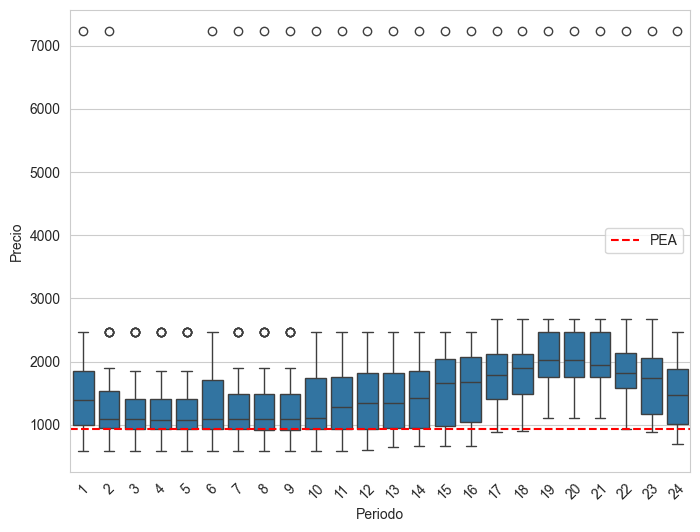

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_dataP, x='Periodo', y='Precio')

# Add horizontal line at y = 20
plt.axhline(y=936.06, color='red', linestyle='--', label='PEA')

# Customize x-axis labels and display
plt.xticks(rotation=45)
plt.legend()
plt.show()

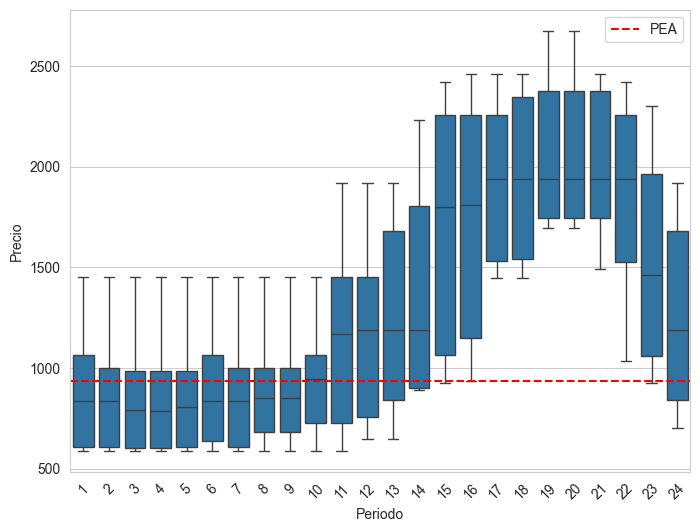

In [15]:
df_dataPO=df_dataP[(pd.to_datetime(df_dataP.Fecha)>=pd.to_datetime('2024-11-06')) & (df_dataP.day_osf==1)]
df_dataPO
# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_dataPO, x='Periodo', y='Precio')

# Add horizontal line at y = 20
plt.axhline(y=936.06, color='red', linestyle='--', label='PEA')

# Customize x-axis labels and display
plt.xticks(rotation=45)
plt.legend()
plt.show()

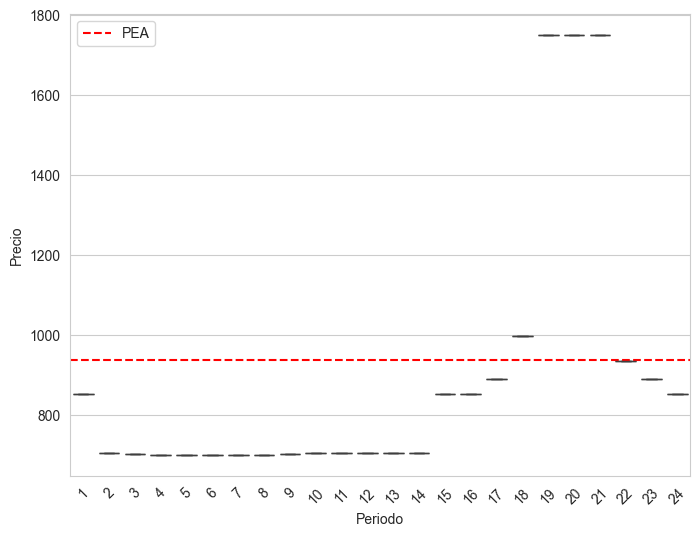

In [16]:
df_dataPS=df_dataP[(pd.to_datetime(df_dataP.Fecha)>=pd.to_datetime('2024-11-06')) & (df_dataP.day_osf==2)]
# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_dataPS, x='Periodo', y='Precio')

# Add horizontal line at y = 20
plt.axhline(y=936.06, color='red', linestyle='--', label='PEA')

# Customize x-axis labels and display
plt.xticks(rotation=45)
plt.legend()
plt.show()

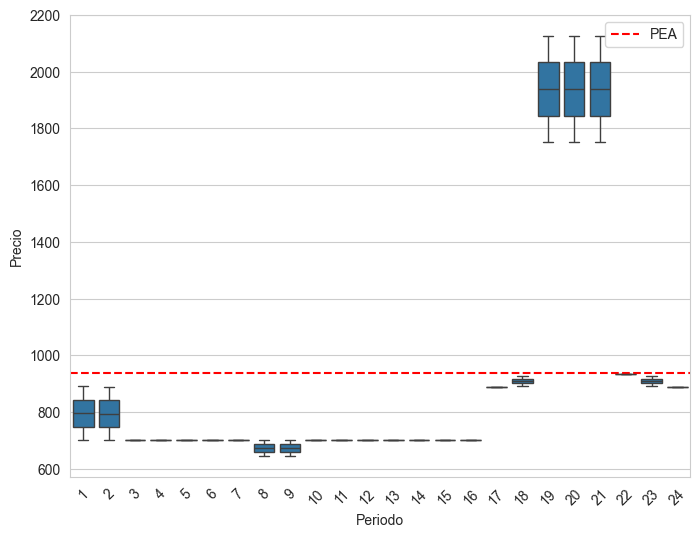

In [17]:
df_dataPF=df_dataP[(pd.to_datetime(df_dataP.Fecha)>=pd.to_datetime('2024-11-06')) & (df_dataP.day_osf==3)]
# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_dataPF, x='Periodo', y='Precio')

# Add horizontal line at y = 20
plt.axhline(y=936.06, color='red', linestyle='--', label='PEA')

# Customize x-axis labels and display
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [18]:
FechaIniSic=dt.date(2024, 9, 30)
# FechaFinSic=dt.date(2024, 9, 30)
FechaFinSic=dt.date(2024, 11, 12)

day = dt.timedelta(days=1)

FechaIter=FechaIniSic

df_dataPB=pd.DataFrame()

while FechaIter <= FechaFinSic:
    
#     print(FechaIter)
    ano = FechaIter.year
    mes=FechaIter.month
    dia=FechaIter.day
    
    ruta=r"C:\Información XM\PUBLICOK\SIC\COMERCIA\\"
    ruta= ruta + str(ano) + '-' + "{:02d}".format(mes) + '\\'
    ruta= ruta + 'trsd' + "{:02d}".format(mes) + "{:02d}".format(dia) + '.tx1'
    df_aux = pd.read_csv(ruta, sep=';', header=None,encoding="ISO-8859-1")
    df_aux=df_aux[(df_aux[0]=='PBNA')]
    df_aux['Fecha']=FechaIter
    df_dataPB=pd.concat([df_dataPB,df_aux])
    

    

    FechaIter=FechaIter+day

df_dataPB=df_dataPB.drop([0,1],axis=1)
df_dataPB
# Definir tipo de día
df_dataPB['day_osf']=df_dataPB.apply(lambda row: typedays(row,weekday=False),axis=1)
# Definir día de la semana
df_dataPB['day_w']=df_dataPB.apply(lambda row: typedays(row,weekday=True),axis=1)
# Definir los periodos en una columna
df_dataPB = pd.melt(df_dataPB, id_vars=['Fecha','day_osf','day_w'], var_name='Periodo', value_name='PrecioI')
df_dataPB['PrecioI']=df_dataPB['PrecioI'].astype(float).round(2)
df_dataPB['Periodo']=df_dataPB['Periodo']-1


df_dataPB

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Información XM\\PUBLICOK\\SIC\\COMERCIA\\\\2024-11\\trsd1110.tx1'

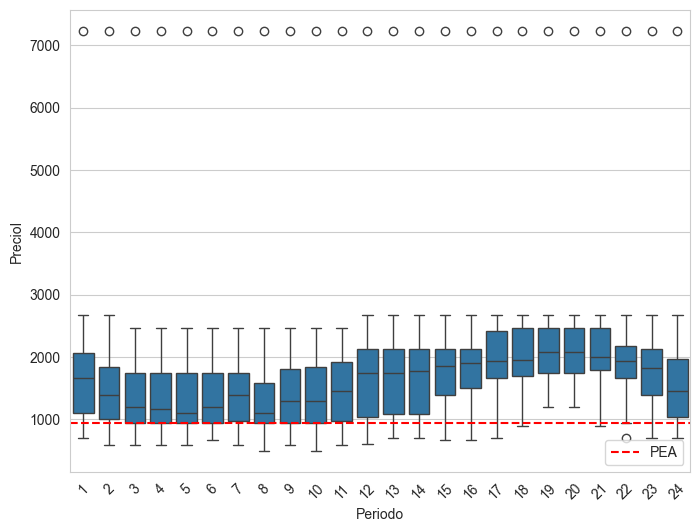

In [ ]:
# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_dataPB, x='Periodo', y='PrecioI')
df_dataPB
# Add horizontal line at y = 20
plt.axhline(y=936.06, color='red', linestyle='--', label='PEA')

# Customize x-axis labels and display
plt.xticks(rotation=45)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


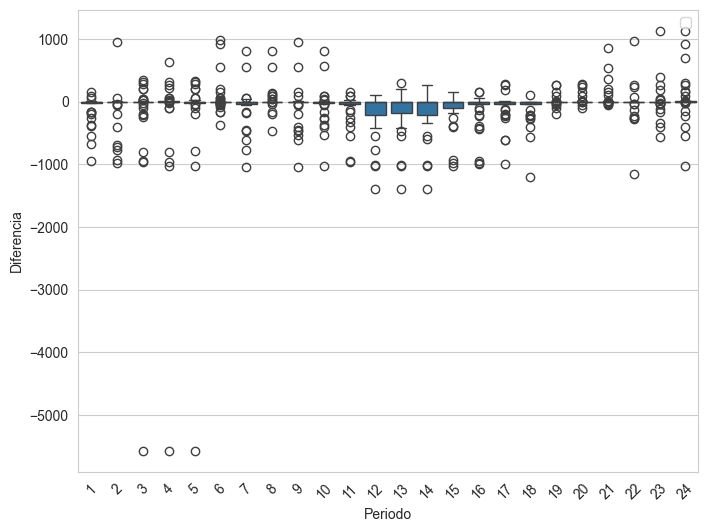

In [ ]:
df_Error=df_dataPB.merge(df_dataP,left_on=['Fecha','Periodo'],right_on=['Fecha','Periodo'],how='left')
df_Error['Diferencia']=df_Error['Precio']-df_Error['PrecioI']

# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_Error, x='Periodo', y='Diferencia')
# Add horizontal line at y = 20
# plt.axhline(y=936.06, color='red', linestyle='--', label='PEA')

# Customize x-axis labels and display
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
df_ErrorMax=df_Error[(df_Error['Diferencia']==df_Error['Diferencia'].max())]
df_ErrorMax

,Fecha,day_osf_x,day_w_x,Periodo,PrecioI,day_osf_y,day_w_y,Precio,Diferencia
941,2024-11-08,1,4,23,1000.01,1,4,2128.289,1128.279


### Cáclculo de Embalse

In [19]:
# Descargar información de sinergox
FechaIni=dt.date(2024, 9, 30)
FechaFin=dt.date(2025, 1, 19)

In [20]:
# Unit kWh
df_VolumenU= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "VoluUtilDiarEner",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Embalse",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_VolumenU.rename(columns={'Value':'VolUtil'},inplace=True)
df_VolumenU['VolUtil'] = df_VolumenU['VolUtil']/1e6

In [21]:
# Unit kWh
df_VolUtilM3= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "VoluUtilDiarMasa",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Embalse",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_VolUtilM3.rename(columns={'Value':'VolUtilM3'},inplace=True)
df_VolUtilM3['VolUtilM3'] = df_VolUtilM3['VolUtilM3']/1e6

In [22]:
# Unit kWh
df_CapUtilEmb= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "CapaUtilDiarEner",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Embalse",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_CapUtilEmb.rename(columns={'Value':'CapUtil'},inplace=True)
df_CapUtilEmb['CapUtil'] = df_CapUtilEmb['CapUtil']/1e6

In [23]:
df_CapRec= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "CapEfecNeta",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Recurso",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_CapRec['Value'] = df_CapRec['Value']/1e3
df_CapRec.rename(columns={'Value':'CEN'},inplace=True)
df_CapRec=df_CapRec.drop(['Date'],axis=1)

In [24]:
df_CapRec=df_CapRec.drop_duplicates()

In [25]:
delta=dt.timedelta(days=1)
dFecha=FechaIni

df_NEPDay=pd.DataFrame()
df_NPVDay=pd.DataFrame()

while dFecha<=FechaFin:
    # Get the number of days in the month
    days_in_month = calendar.monthrange(dFecha.year, dFecha.month)[1]

    month=dFecha.month
    day=dFecha.day

    for ind in NEPmes.index:
        
        if ind=='PENOL':
            stop=1
        if month<12:
            NEP= max(0,min(NPVmes.loc[ind,month] ,(((NEPmes.loc[ind,month+1] - NEPmes.loc[ind,month])/days_in_month)*(day-1)) + NEPmes.loc[ind,month]))
        else:
            NEP= max(0,min(NPVmes.loc[ind,month] ,(((NEPmes.loc[ind,1] - NEPmes.loc[ind,month])/days_in_month)*(day-1)) + NEPmes.loc[ind,month]))

        df_NEPDay=pd.concat([df_NEPDay,pd.DataFrame({'Date':[dFecha],'Embalse_Sinergox':[ind],'NEP%':[NEP]})])
        df_NPVDay=pd.concat([df_NPVDay,pd.DataFrame({'Date':[dFecha],'Embalse_Sinergox':[ind],'NPV%':[NPVmes.loc[ind,month]]})])

    dFecha=dFecha + delta

df_NEPDay['Date']=pd.to_datetime(df_NEPDay['Date'])
df_NPVDay['Date']=pd.to_datetime(df_NPVDay['Date'])
# df_NEPDay.info()

In [26]:
# Parámetros de embalse
delta=dt.timedelta(days=1)
deltaN=dt.timedelta(days=-1)

df_data=df_VolumenU.copy()
df_data=df_data.merge(df_CapUtilEmb,left_on=['Date','Name'],right_on=['Date','Name'], how='left')[['Date','Name', 'CapUtil', 'VolUtil']]
df_data=df_data.merge(df_VolUtilM3,left_on=['Date','Name'],right_on=['Date','Name'], how='left')[['Date','Name', 'CapUtil', 'VolUtil','VolUtilM3']]
df_data=df_data.merge(df_NEPDay,left_on=['Date','Name'],right_on=['Date','Embalse_Sinergox'], how='left')[['Date','Name', 'CapUtil', 'VolUtil','VolUtilM3','NEP%']]
df_data['NEP']=df_data['CapUtil']*df_data['NEP%']
df_data=df_data.merge(df_NPVDay,left_on=['Date','Name'],right_on=['Date','Embalse_Sinergox'], how='left')[['Date','Name', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%']]

# Unir las plantas con la información de embalse inicial
df_data=df_DataPlt.merge(df_data,left_on=['Embalse_Sinergox'],right_on=['Name'], how='left')[['Date','Planta_Sinergox','Plt_Despacho','CodigoSIC','Embalse_Sinergox','FC_Planta', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%']]

# Convertir el volumen del emblase a energía en GWh para cada embalse, esto no tiene en cuenta la energía que se generaría aguas abajo en la cadena
df_data['NEM']=df_data['VolUtilM3']*df_data['FC_Planta']/3.6

# Renombrar los embalses de guatron
df_data.loc[df_data['Embalse_Sinergox'] == 'MIRAFLORES', 'FC_Planta'] = 0
df_data.loc[df_data['Embalse_Sinergox'] == 'MIRAFLORES', 'Embalse_Sinergox'] = 'TRONERAS'

# Renombrar los embalses del agregado de bogotá para agergrarlos
df_data.loc[df_data['Embalse_Sinergox'] == 'MUNA', 'FC_Planta'] = 0
df_data.loc[df_data['Embalse_Sinergox'] == 'MUNA', 'Embalse_Sinergox'] = 'AGREGADO BOGOTA'

df_data.loc[df_data['Embalse_Sinergox'] == 'CHUZA', 'FC_Planta'] = 0
df_data.loc[df_data['Embalse_Sinergox'] == 'CHUZA', 'Embalse_Sinergox'] = 'AGREGADO BOGOTA'


df_data=df_data.groupby(['Date', 'Planta_Sinergox','Plt_Despacho', 'CodigoSIC', 'Embalse_Sinergox'])[['FC_Planta','CapUtil', 'VolUtil', 'VolUtilM3', 'NEP%', 'NPV%', 'NEM']].sum()
df_data=df_data.reset_index()

df_data['NPV']=df_data['CapUtil']*df_data['NPV%']
df_data['NEP']=df_data['CapUtil']*df_data['NEP%']

df_Aux_1=df_data[['Date','Planta_Sinergox','NEM']]
df_Aux_1['Date']=df_Aux_1['Date'] + pd.to_timedelta(1, unit='D')
df_Aux_1=df_Aux_1.rename(columns={'NEM':'NEM_1'})
df_data=df_data.merge(df_Aux_1,left_on=['Date','Planta_Sinergox'],right_on=['Date','Planta_Sinergox'], how='left')[['Date','Planta_Sinergox','Plt_Despacho','CodigoSIC','Embalse_Sinergox','FC_Planta', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV','NEM','NEM_1']]

df_Aux_1=df_data[['Date','Planta_Sinergox','NPV']]
df_Aux_1['Date']=df_Aux_1['Date'] + pd.to_timedelta(1, unit='D')
df_Aux_1=df_Aux_1.rename(columns={'NPV':'NPV_1'})
df_data=df_data.merge(df_Aux_1,left_on=['Date','Planta_Sinergox'],right_on=['Date','Planta_Sinergox'], how='left')[['Date','Planta_Sinergox','Plt_Despacho','CodigoSIC','Embalse_Sinergox','FC_Planta', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV','NEM','NEM_1','NPV_1']]

df_data=df_data.merge(df_QEVE,left_on=['Date','CodigoSIC'],right_on=['FECHA','CodigoSIC'], how='left')[['Date','Planta_Sinergox','Plt_Despacho','CodigoSIC','Embalse_Sinergox','FC_Planta', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV','NEM','NEM_1','NPV_1','VALOR']]
df_data=df_data.rename(columns={'VALOR':'QEVE'})
df_data['QEVE']=df_data['QEVE'].fillna(0)

df_data=df_data.merge(df_EVE,left_on=['Date','CodigoSIC'],right_on=['FECHA','CodigoSIC'], how='left')[['Date','Planta_Sinergox','Plt_Despacho','CodigoSIC','Embalse_Sinergox','FC_Planta', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV','NEM','NEM_1','NPV_1','QEVE','VALOR']]
df_data=df_data.rename(columns={'VALOR':'EVE'})
df_data['EVE']=df_data['EVE'].fillna(0)

df_data=df_data.merge(df_GEVE,left_on=['Date','CodigoSIC'],right_on=['FECHA','CodigoSIC'], how='left')[['Date','Planta_Sinergox','Plt_Despacho','CodigoSIC','Embalse_Sinergox','FC_Planta', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV','NEM','NEM_1','NPV_1','QEVE','EVE','VALOR']]
df_data=df_data.rename(columns={'VALOR':'GEVE'})
df_data['GEVE']=df_data['GEVE'].fillna(0)

df_data=df_data.merge(df_CapRec,left_on=['CodigoSIC'],right_on=['Code'], how='left')[['Date','Planta_Sinergox','Plt_Despacho','CodigoSIC','Embalse_Sinergox'
                                                                                                        ,'FC_Planta', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV'
                                                                                                        ,'NEM','NEM_1','NPV_1','QEVE','EVE','GEVE','CEN']]

# Integración de los valores calculados en el despacho
FechaIniDes= FechaFinLiq + delta 

FechaIter=FechaIniDes 

l_Recursos=df_dataD['Recurso'].drop_duplicates().reset_index(drop=True)

while FechaIter<=FechaFinDes:

    
    for rec in l_Recursos:
        df_data.loc[(df_data['Date'] == pd.to_datetime(FechaIter)) & (df_data['Plt_Despacho'] == rec), 'EVE'] =  df_dataD.loc[(df_dataD['Fecha(t+1)'] == pd.to_datetime(FechaIter)) & (df_dataD['Recurso'] == rec),'Compra(t+1)'].values[0]

        if FechaIter>FechaIniDes:
            df_data.loc[(df_data['Date'] == pd.to_datetime(FechaIter+deltaN)) & (df_data['Plt_Despacho'] == rec), 'QEVE'] =  df_dataD.loc[(df_dataD['Fecha(t+1)'] == pd.to_datetime(FechaIter)) & (df_dataD['Recurso'] == rec),'Compromiso(t)'].values[0]
            df_data.loc[(df_data['Date'] == pd.to_datetime(FechaIter+deltaN)) & (df_data['Plt_Despacho'] == rec), 'GEVE'] =  df_dataD.loc[(df_dataD['Fecha(t+1)'] == pd.to_datetime(FechaIter)) & (df_dataD['Recurso'] == rec),'EntregaEstimada(t)'].values[0]

    FechaIter=FechaIter + delta


# Cálculo de la energía remanente
# ER_t=NEM_t-1-NEP_t-(QEVE_t-GEVE_t)
df_data['ER']=df_data['NEM_1']-df_data['NEP']-df_data['QEVE']
df_data['ER'] = df_data['ER'].clip(lower=0)

df_data['%aNPV'] = 100*(df_data['NPV']-df_data['NEM'])/df_data['NPV']

df_data['R1']=df_data['ER']>0
df_data['R2']=df_data['NEM_1']<df_data['NPV_1']

df_data['%aCapU']=100*(df_data['CapUtil']-df_data['NEM'])/df_data['CapUtil']




# Si tiene energía EVE o QUEVE es lo primero que se entrega al sistema
# df_data[(df_data.Name=='URRA1') & (pd.to_datetime(df_NEPDay.Date)<=pd.to_datetime('2024-10-31'))]
# df_data[(pd.to_datetime(df_data.Date)==pd.to_datetime('2024-11-05')) & (df_data.Embalse_Sinergox=='CHUZA')]
# df_data[(pd.to_datetime(df_data.Date)==pd.to_datetime('2024-10-31'))][['Date','Planta_Sinergox','Embalse_Sinergox', 'CapUtil','VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV','NEM','NEM_1','NPV_1','QEVE','EVE']]
df_data[(pd.to_datetime(df_data.Date)==pd.to_datetime('2025-01-06'))][['Date','Planta_Sinergox','Embalse_Sinergox', 'CapUtil','VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV','NEM','NEM_1','NPV_1','QEVE','EVE','ER','%aNPV','R1','R2','%aCapU','CEN']]


,Date,Planta_Sinergox,Embalse_Sinergox,CapUtil,VolUtil,VolUtilM3,NEP%,NPV%,NEP,NPV,...,NEM_1,NPV_1,QEVE,EVE,ER,%aNPV,R1,R2,%aCapU,CEN
2055,2025-01-06,ALBAN,ALTOANCHICAYA,37.167158,13.1812,11.370,0.201290,0.64,7.481389,23.786981,...,12.694092,23.786981,0.0,0.0,5.212702,44.587385,True,True,64.535926,427.0
2056,2025-01-06,BETANIA,BETANIA,120.614130,98.4220,600.867,0.268387,1.00,32.371276,120.614130,...,102.911004,120.614130,0.0,0.0,70.539728,18.396499,True,True,18.396499,540.0
2057,2025-01-06,CALIMA,CALIMA1,219.014076,100.6164,195.220,0.020000,1.00,4.380282,219.014076,...,99.882367,219.014076,0.0,0.0,95.502085,54.060387,True,True,54.060387,132.0
2058,2025-01-06,CHIVOR,ESMERALDA,1124.685848,864.8439,448.245,0.565806,1.00,636.354509,1124.685848,...,855.430771,1124.685848,0.0,0.0,219.076262,23.101742,True,True,23.101742,1000.0
2059,2025-01-06,EL QUIMBO,EL QUIMBO,1080.734336,696.2398,1478.530,0.227097,1.00,245.431281,1080.734336,...,448.261808,1080.734336,0.0,0.0,202.830527,57.992373,True,True,57.992373,400.0
2060,2025-01-06,GUATAPE,PENOL,4114.630858,3215.4511,814.430,0.066774,0.99,274.751157,4073.484549,...,1606.169824,4073.484549,0.0,0.0,1331.418667,60.431856,True,True,60.827538,560.0
2061,2025-01-06,GUATRON,TRONERAS,64.170240,34.7923,10.410,0.429032,0.97,27.531103,62.245133,...,27.988877,62.245133,0.0,0.0,0.457774,58.685653,True,True,59.925084,512.0
2062,2025-01-06,GUAVIO,GUAVIO,1449.344766,1346.7112,492.255,0.457419,1.00,662.958348,1449.344766,...,1339.942845,1449.344766,0.0,0.0,676.984497,7.081186,True,True,7.081186,1250.0
2063,2025-01-06,ITUANGO,ITUANGO,65.920800,25.9109,51.884,0.000000,0.00,0.000000,0.000000,...,25.484652,0.000000,0.0,0.0,25.484652,-inf,True,False,60.690441,1200.0
2064,2025-01-06,JAGUAS,SAN LORENZO,424.512884,392.0259,149.150,0.464194,0.95,197.056142,403.287240,...,98.921521,403.287240,0.0,0.0,0.000000,75.613448,False,True,76.832776,170.0


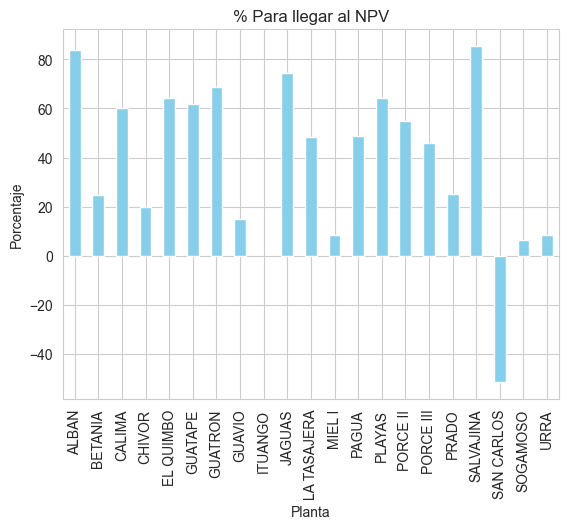

In [27]:
# Bar plot using Pandas
df_plot=df_data[(pd.to_datetime(df_data.Date)==pd.to_datetime('2024-12-22'))]

df_plot.plot(x='Planta_Sinergox', y='%aNPV', kind='bar', legend=False, color='skyblue')
# Add labels and title
plt.xlabel('Planta')
plt.ylabel('Porcentaje')
plt.title('% Para llegar al NPV')
plt.show()

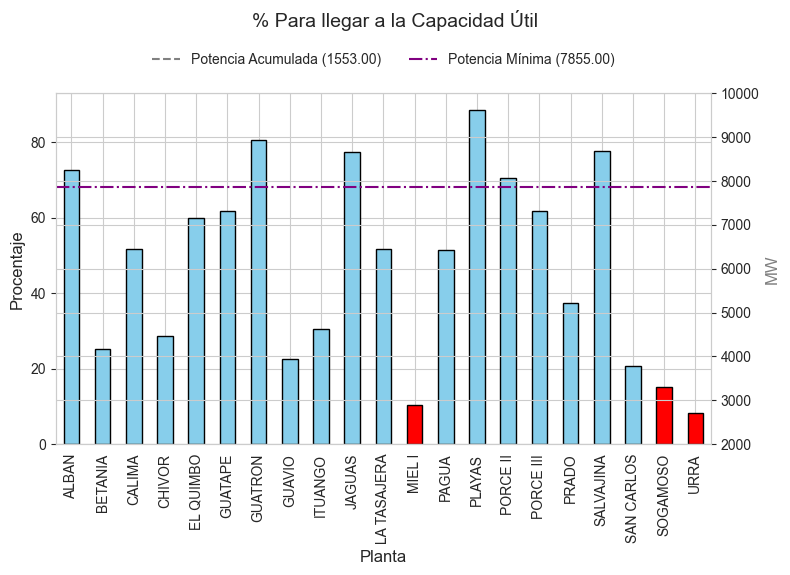

In [37]:
# Bar plot using Pandas
df_plot=df_data[(pd.to_datetime(df_data.Date)==pd.to_datetime('2025-01-19'))]

ValorCap = 20

CENSum = df_plot.loc[df_plot['%aCapU'] < ValorCap, 'CEN'].sum()

# Assign colors based on the threshold for each bar
colors_value1 = ['red' if v < ValorCap else 'skyblue' for v in df_plot['%aCapU']]

# Set the index for categories
df_plot.set_index('Planta_Sinergox', inplace=True)

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the bar chart on the primary axis
df_plot['%aCapU'].plot(kind='bar', ax=ax1, color=colors_value1, edgecolor='black')
ax1.set_ylabel('Procentaje', fontsize=12)
ax1.set_xlabel('Planta', fontsize=12)
# ax1.set_title('% Para llegar a la Capacidad Útil', fontsize=14)
# ax1.tick_params(axis='y', colors='black')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.axhline(y=CENSum, color='gray', linestyle='--', label=f'Potencia Acumulada ({CENSum:.2f})')
ax2.set_ylabel('MW', fontsize=12, color='gray')
# ax2.tick_params(axis='y', colors='gray')

# Add the second threshold line
ax2.axhline(y=7855, color='purple', linestyle='-.', label=f'Potencia Mínima ({7855:.2f})')

# Add a legend for the threshold
ax2.set_ylim(2000, 10000)  # Example: Minimum 0, Maximum 50

# Add a legend for the thresholds and move it outside
ax2.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),  # Adjust placement (centered at the top)
    ncol=2,  # Place legends in a single row with 2 columns
    frameon=False
)

# Add the title and position it above the legend
fig.suptitle(
    '% Para llegar a la Capacidad Útil', 
    fontsize=14, 
    y=0.95  # Move the title higher than the legend
)

# Show the plot
# plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# df_plot.plot(x='Planta_Sinergox', y='%aCapU', kind='bar', legend=False, color='skyblue')
# # Add labels and title
# plt.xlabel('Planta')
# plt.ylabel('Porcentaje')
# plt.title('% Para llegar a la Capacidad Útil')
# plt.show()

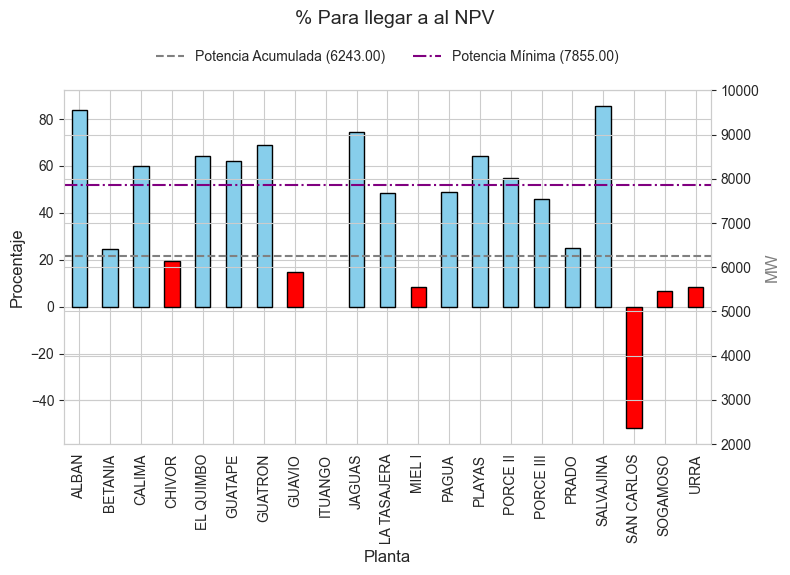

In [29]:
# Bar plot using Pandas
df_plot=df_data[(pd.to_datetime(df_data.Date)==pd.to_datetime('2024-12-22'))]

ValorCap = 20

CENSum = df_plot.loc[df_plot['%aNPV'] < ValorCap, 'CEN'].sum()

# Assign colors based on the threshold for each bar
colors_value1 = ['red' if v < ValorCap else 'skyblue' for v in df_plot['%aNPV']]

# Set the index for categories
df_plot.set_index('Planta_Sinergox', inplace=True)

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the bar chart on the primary axis
df_plot['%aNPV'].plot(kind='bar', ax=ax1, color=colors_value1, edgecolor='black')
ax1.set_ylabel('Procentaje', fontsize=12)
ax1.set_xlabel('Planta', fontsize=12)
# ax1.set_title('% Para llegar a la Capacidad Útil', fontsize=14)
# ax1.tick_params(axis='y', colors='black')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.axhline(y=CENSum, color='gray', linestyle='--', label=f'Potencia Acumulada ({CENSum:.2f})')
ax2.set_ylabel('MW', fontsize=12, color='gray')
# ax2.tick_params(axis='y', colors='gray')

# Add the second threshold line
ax2.axhline(y=7855, color='purple', linestyle='-.', label=f'Potencia Mínima ({7855:.2f})')

# Add a legend for the threshold
ax2.set_ylim(2000, 10000)  # Example: Minimum 0, Maximum 50

# Add a legend for the thresholds and move it outside
ax2.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),  # Adjust placement (centered at the top)
    ncol=2,  # Place legends in a single row with 2 columns
    frameon=False
)

# Add the title and position it above the legend
fig.suptitle(
    '% Para llegar a al NPV', 
    fontsize=14, 
    y=0.95  # Move the title higher than the legend
)

# Show the plot
# plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

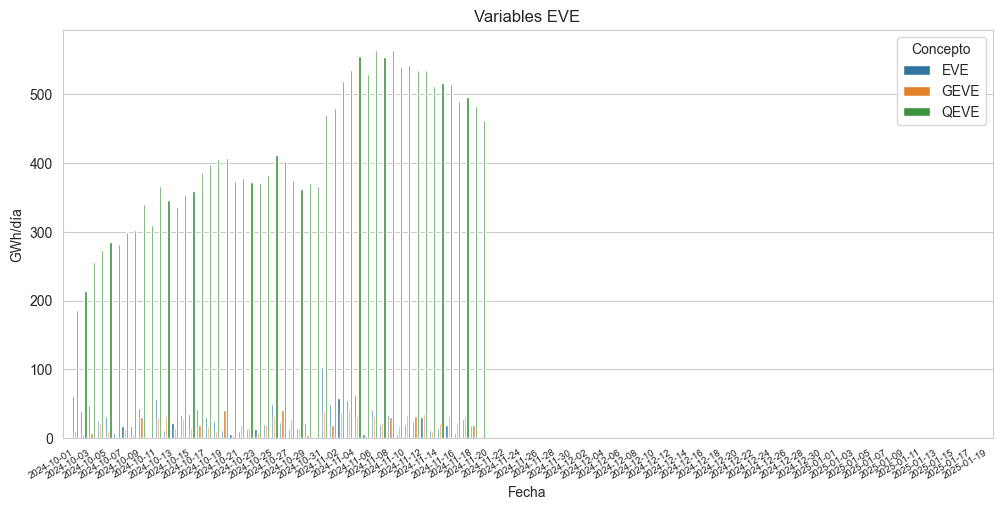

In [30]:
# Plot the EVE, QEVE and GEVE again

l_Conc=['EVE','QEVE','GEVE']

df_plt=pd.DataFrame()

for con in l_Conc:
    df_Aux=df_data[['Date','Planta_Sinergox',con]]
    df_Aux=df_Aux.rename(columns={con:'valor'})
    df_Aux['Concepto']=con

    df_plt=pd.concat([df_plt,df_Aux],axis=0)

df_plt=df_plt.groupby(['Date','Concepto'])[['valor']].sum()
df_plt=df_plt.reset_index()

plotEVE(df_plt,sX='Date',sY='valor',sH='Concepto',ticks=1)

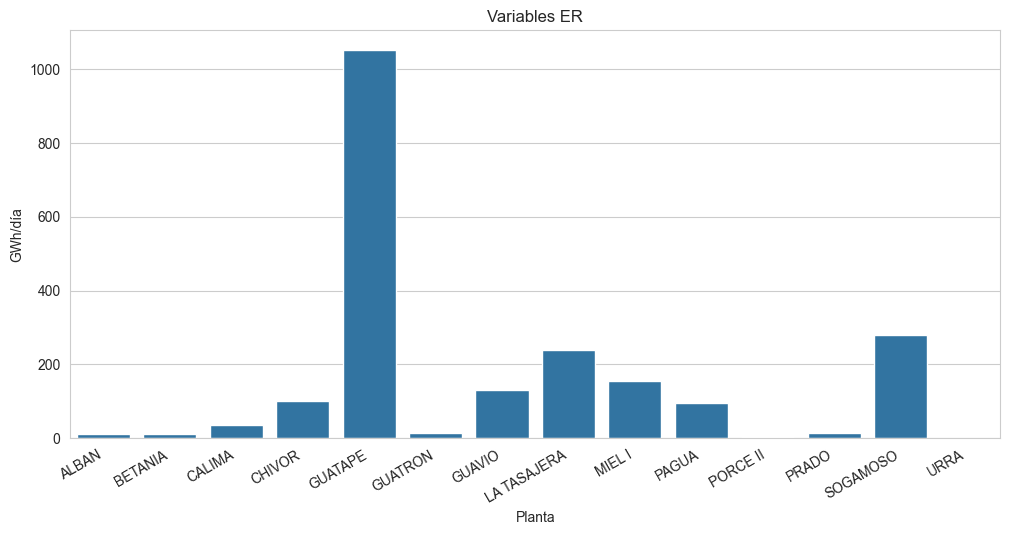

In [31]:
df_ER = df_data.loc[(df_data['Date'] == pd.to_datetime(FechaFinDes + deltaN)) & (df_data['R1'] == True) & (df_data['R2'] == True), ['Date','Planta_Sinergox', 'ER']]

# Create the bar plot
plt.figure(figsize=(12, 6))

sns.barplot(data=df_ER, x='Planta_Sinergox', y='ER')

# Set plot title and labels
plt.title('Variables ER')
plt.xlabel('Planta')
plt.ylabel('GWh/día')

plt.gcf().autofmt_xdate()
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Display the plot
plt.show()

In [32]:
# Unit kWh
df_OEF= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "ObligEnerFirme",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Recurso",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
# df_VolumenU.rename(columns={'Value':'VolUtil'},inplace=True)
# df_VolumenU['VolUtil'] = df_VolumenU['VolUtil']/1e6

In [33]:
df_Rec= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "ListadoRecursos",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Sistema",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_Rec=df_Rec.drop('Date',axis=1)

In [34]:
df_OEF

,Id,Code,Value,Date
0,Recurso,2QBW,450230.45,2024-09-30
1,Recurso,2QEK,0.00,2024-09-30
2,Recurso,2QFU,0.00,2024-09-30
3,Recurso,2QRL,15386.97,2024-09-30
4,Recurso,2QV2,87174.00,2024-09-30
...,...,...,...,...
22061,Recurso,ZPA2,0.00,2025-01-19
22062,Recurso,ZPA3,0.00,2025-01-19
22063,Recurso,ZPA4,0.00,2025-01-19
22064,Recurso,ZPA5,0.00,2025-01-19


In [35]:
df_dataOEF=df_OEF.copy()
df_dataOEF=df_dataOEF.merge(df_Rec,left_on=['Code'],right_on=['Values_Code'], how='left')[['Date','Code','Values_Name', 'Value']]

In [36]:
df_dataOEF.to_csv('OEF.csv')